In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from chitaxi.datasets import loader, builder

# %config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2
plt.style.use('seaborn')
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'w'

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

# ChiTaxi 03 - Baseline Linear Regression

In this section, we are going to use the Linear Regression model as our benchmark.

We are going to use the features generated from 2015, to predict the each taxi's aggregated revenues in the next year, 2016.

## Load Data

In [2]:
loader.list_feathers()

2015_features.feather
Base_Xtest.feather
Base_Xtrain.feather
Base_Ytest.feather
Base_Ytrain.feather
clean_2013.feather
clean_2014.feather
clean_2015.feather
clean_2016.feather
labels_2016.feather


In [3]:
df_2015 = loader.read_feather("2015_features.feather")
df_2015.set_index('taxi_id', inplace=True)
df_2016 = loader.read_feather("labels_2016.feather")
df_2016.set_index('taxi_id', inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [4]:
bd = builder.Builder()
data = bd.merge_data(df_2015, df_2016)

2018-10-11 18:27:43 - INFO - Merging features and labels...
2018-10-11 18:27:43 - INFO - We have 7155 unique ids in 2015
2018-10-11 18:27:43 - INFO - 746 of them (10.42628%) dropped (nan) in 2016


While loading the data, we noticed that not every taxi in 2015 is still working in 2016. In this analysis, we simply removed those uncontinuous data points. Alternatively, we could force them have 0 revenues in 2016, and to see if our model can capture those noises.

### 2015 Revenue vs. 2016 Revenue

In the plot below, each data point is a unique taxi. We want to explore how their revenue changes at the highest level. 

There are some `taxi` have little revenue in 2015 and suddenly got increased in 2016 and some `taxi` declined to almost 0 revenue in 2016. (See points along the x=0 and y=0 lines) Those points may bring model challenges regarding correct predictions.

In [5]:
y2015 = df_2015[['total_sum_' + str(i+1) for i in range(12)]].sum(axis=1)

In [6]:
df_two = pd.merge(pd.DataFrame(y2015), df_2016, left_index=True, right_index=True)
df_two.columns = ['2015', '2016']

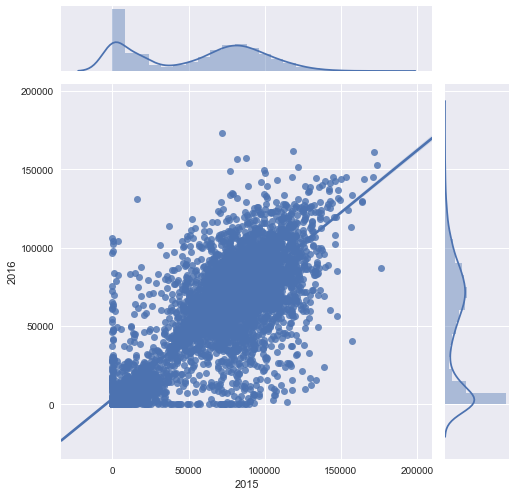

In [7]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g = sns.jointplot("2015", "2016", data=df_two, kind="reg",height=7)

## Train Test Split

By performing the 0.2 size train test split, we replicated the distribution we observed in sections before.

In [8]:
X_train, X_test, y_train, y_test = bd.train_split(data, 'trip_total', seed=999, filename="Base")

Text(0.5,1,'Test Data')

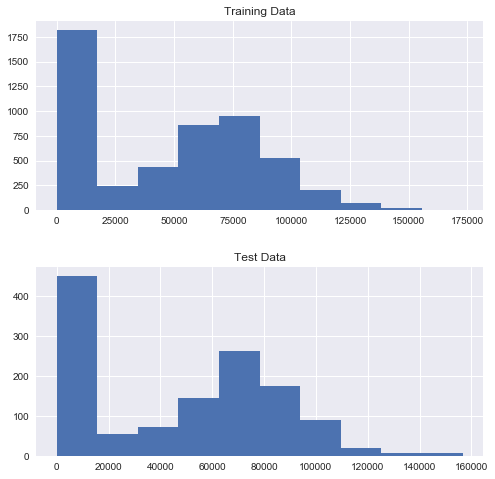

In [9]:
fig, ax = plt.subplots(2,1,figsize=(8,8))

y_train.hist(ax=ax[0])
ax[0].set_title("Training Data")
y_test.hist(ax=ax[1])
ax[1].set_title("Test Data")

## Baseline: Linear Regression

### Cross Validations

In the 3-fold cross validations on the training data, we plotted the RMSE as the main metric to evaluate if our model is working. The black bar indicates the lowest/highest volatile scores.

> Note: Test here means in-sample test data in each CV validate fold.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


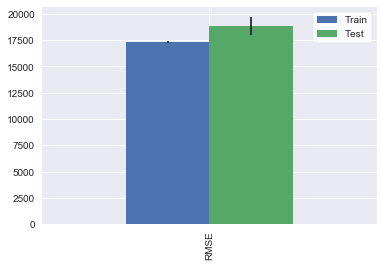

In [10]:
lin_reg = LinearRegression()
score_MSE = {'MSE':make_scorer(mean_squared_error)}
cv_results=cross_validate(lin_reg, X_train, y_train,scoring=score_MSE,return_train_score=True)

erros = {
    "Train": [[np.sqrt(cv_results['train_MSE'].mean())- np.sqrt(cv_results['train_MSE'].min()),
     np.sqrt(cv_results['train_MSE'].max())- np.sqrt(cv_results['train_MSE'].mean())]],
    "Test": [[np.sqrt(cv_results['test_MSE'].mean())- np.sqrt(cv_results['test_MSE'].min()),
     np.sqrt(cv_results['test_MSE'].max())- np.sqrt(cv_results['test_MSE'].mean())]]
}

df = pd.DataFrame({
    'Train': np.sqrt(cv_results['train_MSE'].mean()),
    'Test': np.sqrt(cv_results['test_MSE'].mean())
}, index=['RMSE']).plot(kind='bar', yerr=erros)

### Predictions

By sorting the predictions by the order of the size of actual 2016 revenues, we have plots as below:

* Linear Regression can even have negative predictions which won't make sense
* It failed the prediction harder when extreme values come in, for both low and high values.

In [11]:
lin_reg.fit(X_train, y_train)
y_train_predict = lin_reg.predict(X_train)
y_test_predict = lin_reg.predict(X_test)

In [12]:
y_train_sort = y_train.sort_values('trip_total')
y_train_predict_sort = lin_reg.predict(X_train.loc[y_train_sort.index])

y_test_sort =  y_test.sort_values('trip_total')
y_test_predict_sort = lin_reg.predict(X_test.loc[y_test_sort.index])

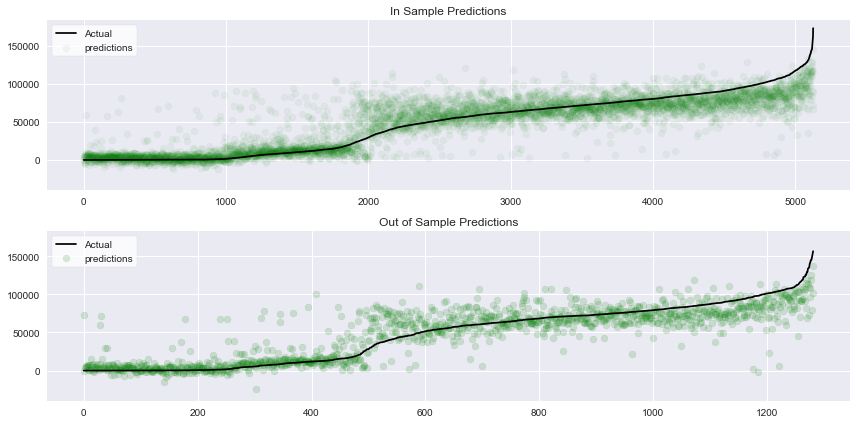

In [13]:
fig, ax = plt.subplots(2,1,figsize=(12,6), sharey=True)

ax[0].scatter(range(len(y_train_sort)), y_train_predict_sort,alpha=0.05, label='predictions', c='g')
ax[0].plot(range(len(y_train_sort)), y_train_sort.values, label='Actual',color='black')
ax[0].set_title("In Sample Predictions")
ax[0].legend()

ax[1].scatter(range(len(y_test_sort)), y_test_predict_sort,alpha=0.15, label='predictions', c='g')
ax[1].plot(range(len(y_test_sort)), y_test_sort.values, label='Actual',color='black')
ax[1].set_title("Out of Sample Predictions")
ax[1].legend()

fig.tight_layout()

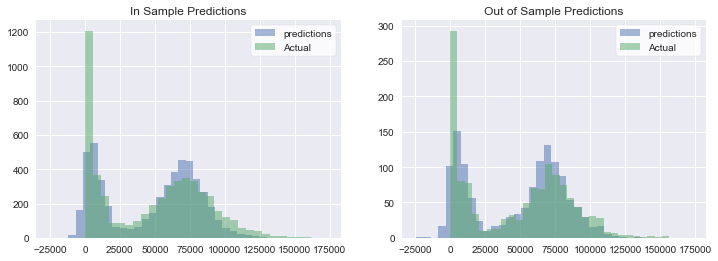

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True)

ax[0].hist(y_train_predict_sort,bins=30,alpha=0.5, label='predictions')
ax[0].hist(y_train_sort.values,bins=30,alpha=0.5, label='Actual')
ax[0].set_title("In Sample Predictions")
ax[0].legend()
ax[1].hist(y_test_predict_sort,bins=30,alpha=0.5, label='predictions')
ax[1].hist(y_test_sort.values,bins=30,alpha=0.5, label='Actual')
ax[1].set_title("Out of Sample Predictions")
ax[1].legend()


### Residuals

By looking at its errors, the conclusion aligns with the plots above. Linear regression model tends to overestimate low revenue taxi and underestimate high revenue taxi. 

We hope to improve this by applying another machine-learning based model.

In [15]:
e_in_sample = y_train_predict_sort - y_train_sort
e_oos = y_test_predict_sort -  y_test_sort

Text(0.5,0,'Actual Revenue')

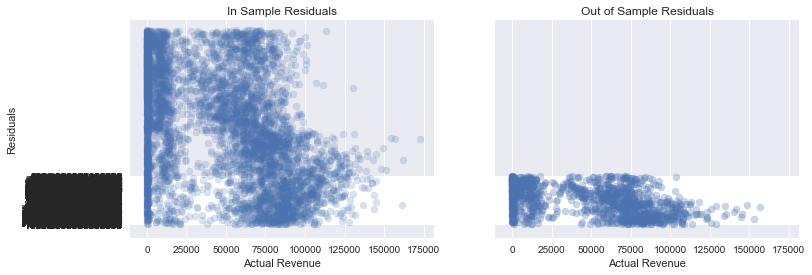

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True, sharey=True)


ax[0].scatter(y_train_sort.values, e_in_sample, alpha=0.2)
ax[0].set_title("In Sample Residuals")
ax[0].set_ylabel("Residuals")
ax[0].set_xlabel("Actual Revenue")
ax[1].scatter(y_test_sort.values,e_oos,alpha=0.3)
ax[1].set_title("Out of Sample Residuals")
ax[1].set_xlabel("Actual Revenue")

## 6.3 Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import time

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False]
              }

# run grid search
rf_ = RandomForestRegressor(n_estimators=300)
grid_search_1 = GridSearchCV(rf_, param_grid=param_grid, scoring = "neg_mean_absolute_error", n_jobs = 6)
grid_search_1.fit(X_train , y_train)
#rf_3.fit(x_train_3 , Y_train_3)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_depth': [3, None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [20]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(grid_search_1.cv_results_)

Model with rank: 1
Mean validation score: -11418.867 (std: 117.314)
Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: -11422.000 (std: 153.499)
Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: -11434.657 (std: 119.001)
Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 10}



In [21]:
Y_predictions_test_1 = grid_search_1.predict(X_test)
lin_mae_1 = mean_absolute_error(y_test, Y_predictions_test_1)

print ("Random Forest Method:")
print ("Test error")
print ("Mean absolute error: ", lin_mae_1)

Y_predictions_test_1_t = grid_search_1.predict(X_train)
lin_mae_1_t = mean_absolute_error(y_train, Y_predictions_test_1_t)

print ("Random Forest Method:")
print ("Train error")
print ("Mean absolute error: ", lin_mae_1_t)

Random Forest Method:
Test error
Mean absolute error:  10815.897896536433
Random Forest Method:
Train error
Mean absolute error:  2338.746186594105


Feature ranking:
1. feature total_sum_12 (0.063442)
2. feature total_sum_10 (0.059034)
3. feature total_sum_11 (0.056441)
4. feature total_sum_8 (0.051517)
5. feature total_sum_6 (0.046412)
6. feature total_sum_4 (0.034691)
7. feature total_sum_9 (0.034476)
8. feature total_sum_7 (0.031637)
9. feature seconds_mean_12 (0.031239)
10. feature count_11 (0.029620)
11. feature seconds_mean_11 (0.028994)
12. feature seconds_mean_6 (0.026454)
13. feature total_sum_5 (0.025810)
14. feature count_6 (0.022614)
15. feature count_9 (0.021506)
16. feature seconds_mean_8 (0.016559)
17. feature total_sum_3 (0.015592)
18. feature count_12 (0.015345)
19. feature count_8 (0.015339)
20. feature seconds_mean_9 (0.015159)
21. feature count_10 (0.015025)
22. feature seconds_mean_10 (0.013569)
23. feature seconds_mean_7 (0.012894)
24. feature seconds_mean_5 (0.012669)
25. feature seconds_mean_2 (0.012109)
26. feature count_5 (0.011393)
27. feature count_4 (0.010291)
28. feature seconds_mean_4 (0.008323)
29. f

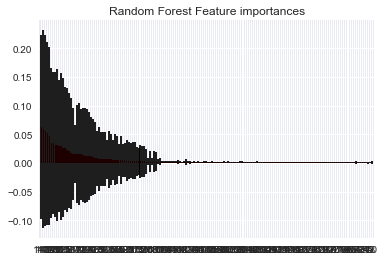

In [46]:
importances = grid_search_1.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in grid_search_1.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, df_2015.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Random Forest Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [17]:
grid_search_1.best_estimator_

NameError: name 'grid_search_1' is not defined

In [51]:
from sklearn.externals import joblib

filename = 'RF_model-best.sav'
joblib.dump(grid_search_1.best_estimator_, filename)

['RF_model-best.sav']

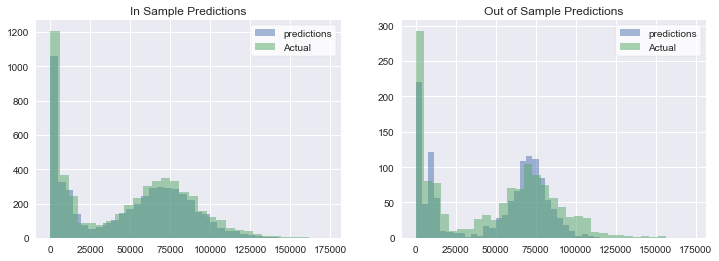

In [53]:

fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True)

ax[0].hist(Y_predictions_test_1_t,bins=30,alpha=0.5, label='predictions')
ax[0].hist(y_train.values,bins=30,alpha=0.5, label='Actual')
ax[0].set_title("In Sample Predictions")
ax[0].legend()
ax[1].hist(Y_predictions_test_1,bins=30,alpha=0.5, label='predictions')
ax[1].hist(y_test.values,bins=30,alpha=0.5, label='Actual')
ax[1].set_title("Out of Sample Predictions")
ax[1].legend()



In [58]:
e_in_sample.shape

NameError: name 'e_in_sample' is not defined

In [ ]:
e_in_sample = Y_predictions_test_1_t.reshape(-1,1) - y_train
e_oos = Y_predictions_test_1.reshape(-1,1) -  y_test

fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True, sharey=True)


ax[0].scatter(Y_predictions_test_1_t, e_in_sample, alpha=0.2)
ax[0].set_title("In Sample Residuals")
ax[0].set_ylabel("Residuals")
ax[0].set_xlabel("Actual Revenue")
ax[1].scatter(Y_predictions_test_1,e_oos,alpha=0.3)
ax[1].set_title("Out of Sample Residuals")
ax[1].set_xlabel("Actual Revenue")

Text(0.5,0,'Actual Revenue')

In [1]:
Y_predictions_test_1_t

NameError: name 'Y_predictions_test_1_t' is not defined

## GBRegression

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

param_grid_2 = {'n_estimators':[100,500], 
            'learning_rate': [0.1,0.05,0.02, 0.01],
            'max_depth':[4,6], 
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0, 0.3] } 


#grid_search.fit(X_train, Y_train)

clf = GradientBoostingRegressor()
grid_search_2 = GridSearchCV(clf, param_grid=param_grid_2, scoring = "neg_mean_absolute_error", n_jobs = 6)
grid_search_2.fit(X_train , y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validati

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'n_estimators': [100, 500], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6], 'min_samples_leaf': [3, 5, 9, 17], 'max_features': [1.0, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [27]:
report(grid_search_2.cv_results_)

Model with rank: 1
Mean validation score: -11395.147 (std: 147.816)
Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 17, 'n_estimators': 500}

Model with rank: 2
Mean validation score: -11405.505 (std: 128.081)
Parameters: {'learning_rate': 0.02, 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 17, 'n_estimators': 500}

Model with rank: 3
Mean validation score: -11418.476 (std: 148.521)
Parameters: {'learning_rate': 0.02, 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 9, 'n_estimators': 500}



In [29]:
Y_predictions_test_2 = grid_search_2.predict(X_test)
lin_mae_2 = mean_absolute_error(y_test, Y_predictions_test_2)

print ("GB Regression Method:")
print ("Test error")
print ("Mean absolute error: ", lin_mae_2)

Y_predictions_test_2_t = grid_search_2.predict(X_train)
lin_mae_2_t = mean_absolute_error(y_train, Y_predictions_test_2_t)

print ("GB Regression Method:")
print ("Train error")
print ("Mean absolute error: ", lin_mae_2_t)

GB Regression Method:
Test error
Mean absolute error:  10790.780670197646
GB Regression Method:
Train error
Mean absolute error:  8221.63940004973


In [48]:
feature_importance = grid_search_2.best_estimator_.feature_importances_
# make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, df_2015.columns[indices[f]], feature_importance[indices[f]]))



Feature ranking:
1. feature total_sum_12 (0.128157)
2. feature total_sum_11 (0.091028)
3. feature total_sum_9 (0.078926)
4. feature total_sum_10 (0.060970)
5. feature total_sum_6 (0.045745)
6. feature count_12 (0.025481)
7. feature total_sum_8 (0.024154)
8. feature total_sum_7 (0.021835)
9. feature total_sum_5 (0.016559)
10. feature total_sum_4 (0.013284)
11. feature max_break_hrs_12 (0.011497)
12. feature max_break_hrs_7 (0.011307)
13. feature total_sum_2 (0.011306)
14. feature count_11 (0.010022)
15. feature count_9 (0.009603)
16. feature seconds_mean_11 (0.007347)
17. feature total_sum_1 (0.007132)
18. feature total_sum_3 (0.007066)
19. feature count_5 (0.006937)
20. feature max_break_hrs_6 (0.006830)
21. feature count_7 (0.006774)
22. feature count_8 (0.006757)
23. feature count_1 (0.006632)
24. feature miles_mean_9 (0.006028)
25. feature count_10 (0.005695)
26. feature count_4 (0.005544)
27. feature miles_mean_7 (0.005345)
28. feature count_2 (0.005218)
29. feature total_mean_12 (

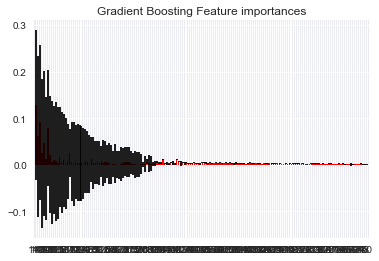

In [43]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Gradient Boosting Feature importances")
plt.bar(range(X_train.shape[1]), feature_importance[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [52]:
from sklearn.externals import joblib

filename = 'GB_model-best.sav'
joblib.dump(grid_search_2.best_estimator_, filename)

['GB_model-best.sav']

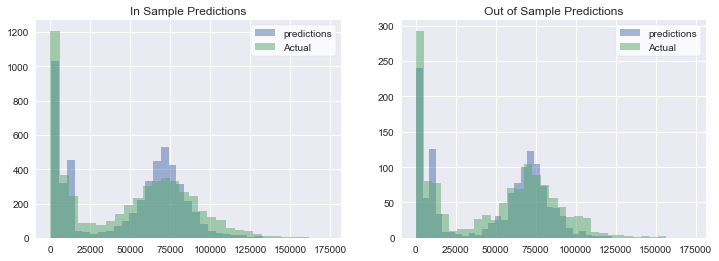

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12,4),sharex=True)

ax[0].hist(Y_predictions_test_2_t,bins=30,alpha=0.5, label='predictions')
ax[0].hist(y_train.values,bins=30,alpha=0.5, label='Actual')
ax[0].set_title("In Sample Predictions")
ax[0].legend()
ax[1].hist(Y_predictions_test_2,bins=30,alpha=0.5, label='predictions')
ax[1].hist(y_test.values,bins=30,alpha=0.5, label='Actual')
ax[1].set_title("Out of Sample Predictions")
ax[1].legend()


